C:\Users\macie\AppData\Local\Temp\ipykernel_25636\840179541.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subdirs, y=file_counts, palette='viridis')


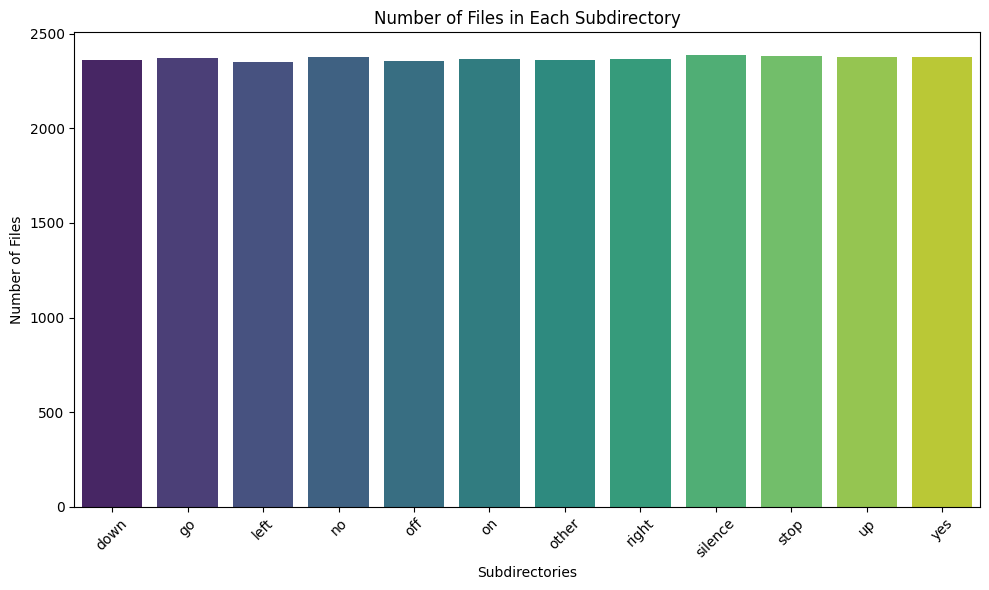

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

parent_dir = '..\\image_folder_reduced_noise_further'

subdirs = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

file_counts = []

# Loop through each subdirectory and count the files
for subdir in subdirs:
    subdir_path = os.path.join(parent_dir, subdir)
    file_count = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
    file_counts.append(file_count)

plt.figure(figsize=(10, 6))
sns.barplot(x=subdirs, y=file_counts, palette='viridis')

plt.xlabel('Subdirectories')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Subdirectory')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


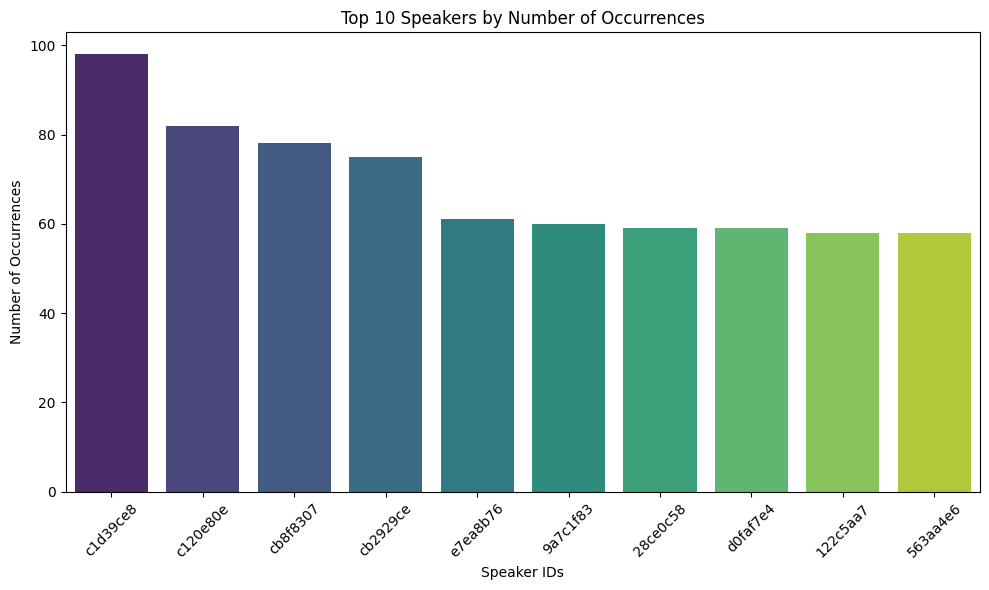

In [13]:
from collections import defaultdict

# Initialize a dictionary to count occurrences of each speaker
speaker_count = defaultdict(int)

# List the subdirectories (assuming they are directly inside the parent directory)
subdirs = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Loop through each subdirectory and count speaker occurrences
for subdir in subdirs:
    subdir_path = os.path.join(parent_dir, subdir)
    if "silence" in subdir_path:
        continue
    
    # Loop through files in each subdirectory
    for filename in os.listdir(subdir_path):
        if os.path.isfile(os.path.join(subdir_path, filename)):
            # Extract the speaker ID (part before '_nohash')
            speaker_id = filename.split('_')[0]
            speaker_count[speaker_id] += 1

# Sort the speaker count dictionary by number of occurrences
sorted_speaker_count = sorted(speaker_count.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 most frequent speakers
top_10_speakers = sorted_speaker_count[:10]

# Separate the speaker IDs and their counts for plotting
speakers, counts = zip(*top_10_speakers)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=speakers, y=counts, palette='viridis',hue=speakers,legend=False)


# Add labels and title
plt.xlabel('Speaker IDs')
plt.ylabel('Number of Occurrences')
plt.title('Top 10 Speakers by Number of Occurrences')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


Maybe we should do sth with the slight imbalance in silence

In [17]:
import pandas as pd
import librosa
import noisereduce as nr
import numpy as np

# Define target directories
target_dirs = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"}

# Initialize an empty list to store data for the DataFrame
data = []

# Define the parent directory containing the target directories
parent_dir = '..\\tensorflow-speech-recognition-challenge\\train\\audio'

# Loop through each target directory
for label in target_dirs:
    dir_path = os.path.join(parent_dir, label)
    
    # Loop through each .wav file in the directory
    for filename in os.listdir(dir_path):
        if filename.endswith(".wav"):
            # Extract the speaker_id and speaker_track_id from the filename
            parts = filename.split('_')
            speaker_id = parts[0]
            speaker_track_id = parts[2].split('.')[0]  # Remove file extension
            
            # Construct the full file path
            filepath = os.path.join(dir_path, filename)
            
            # Load the audio file
            y, sr = librosa.load(filepath, sr=None)
            
            # Noise reduction
            y = nr.reduce_noise(y=y,sr=sr, thresh_n_mult_nonstationary = 12, n_fft = 512) # reducing noise                   
            
            # Calculate duration
            duration = librosa.get_duration(y=y, sr=sr)
            
            # Calculate RMSE (Root Mean Square Energy)
            rmse = librosa.feature.rms(y=y).mean()  # Mean RMSE across frames
            
            # Calculate ZCR (Zero Crossing Rate)
            zcr = librosa.feature.zero_crossing_rate(y).mean()  # Mean ZCR across frames
            
            # Get non-silent intervals and calculate talking duration
            non_silent_intervals = librosa.effects.split(y)
            talking_duration = sum((end - start) / sr for start, end in non_silent_intervals)
            
            # Calculate silence duration
            silence_duration = duration - talking_duration
            
            # Append the data to the list
            data.append({
                "speaker_id": speaker_id,
                "speaker_track_id": speaker_track_id,
                "class": label,
                # "duration": duration,
                "talking_duration": talking_duration,
                "silence_duration": silence_duration,
                "rmse": rmse,
                "zcr": zcr
            })

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Save the DataFrame to a file for later use
df.to_pickle('audio_features.pkl')  # Save as a pickle file (faster to load)
# Alternatively, you can save it as a CSV file
# df.to_csv('audio_features.csv', index=False)

# Print the first few rows of the DataFrame
print(df.head())


  speaker_id speaker_track_id class  talking_duration  silence_duration  \
0   00176480                0  down             0.416             0.584   
1   004ae714                0  down             0.680             0.320   
2   00b01445                0  down             0.584             0.416   
3   00b01445                1  down             0.608             0.392   
4   00f0204f                0  down             0.960             0.040   

       rmse       zcr  
0  0.021437  0.261353  
1  0.009577  0.147995  
2  0.015379  0.114853  
3  0.017065  0.255417  
4  0.004365  0.112534  


C:\Users\macie\AppData\Local\Temp\ipykernel_25636\922403010.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['rmse'], bins=30, kde=True, palette='coolwarm')


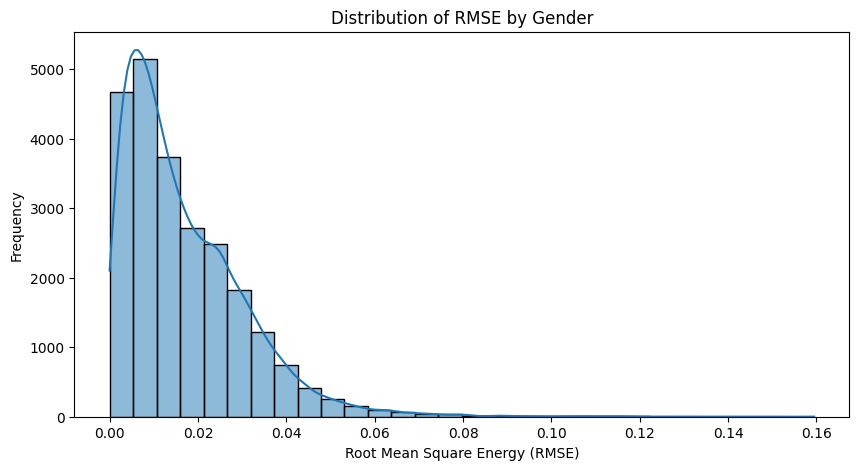

In [18]:

plt.figure(figsize=(10, 5))
sns.histplot(df['rmse'], bins=30, kde=True)
plt.title('Distribution of RMSE by Gender')
plt.xlabel('Root Mean Square Energy (RMSE)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['zcr'], bins=30, kde=True)
plt.title('Distribution of ZCR by Gender')
plt.xlabel('Zero Crossing Rate (ZCR)')
plt.ylabel('Frequency')
plt.show()



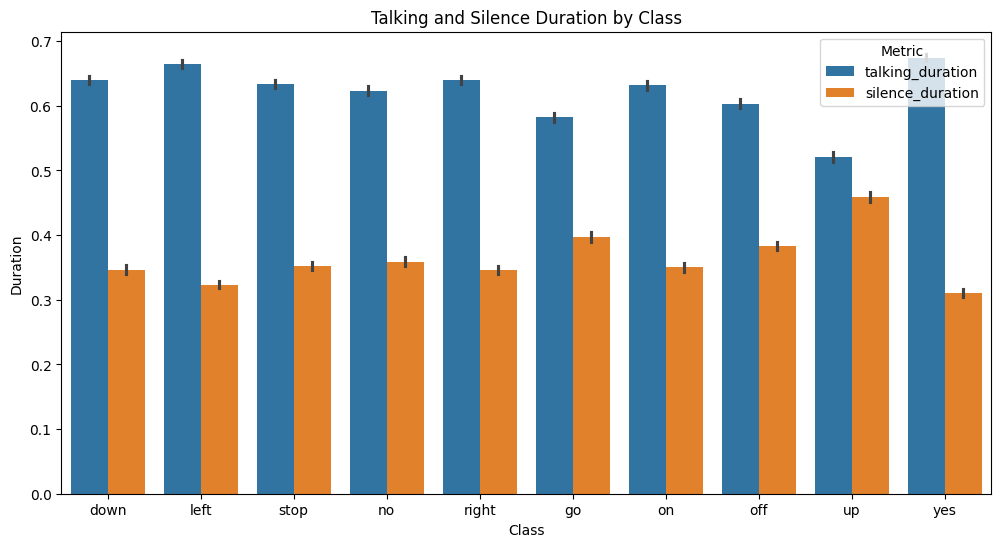

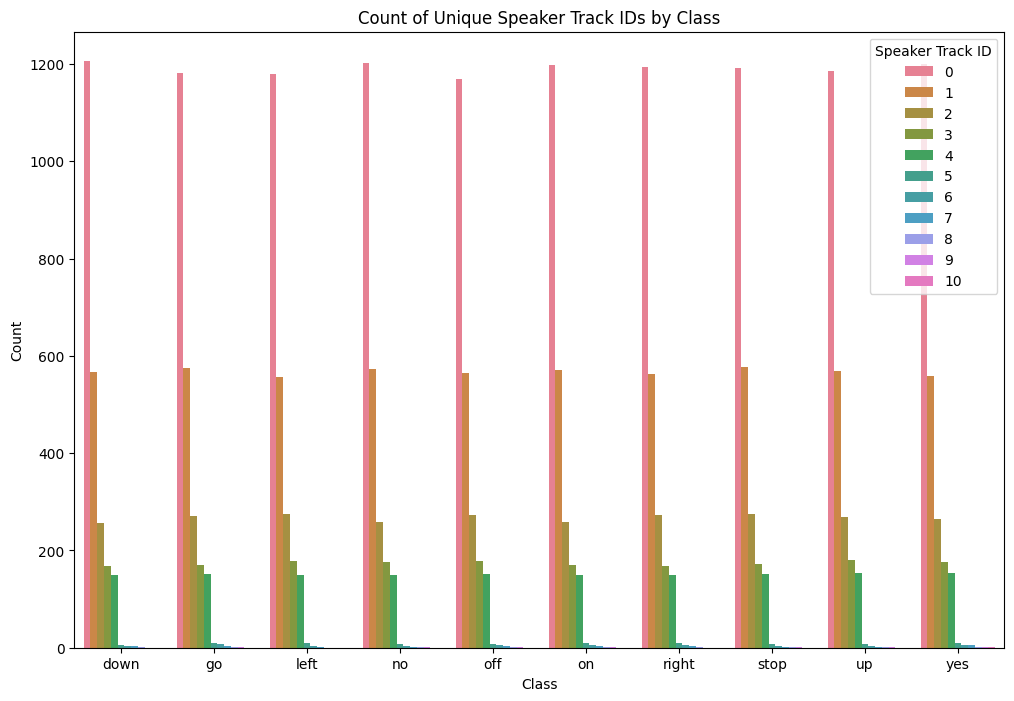

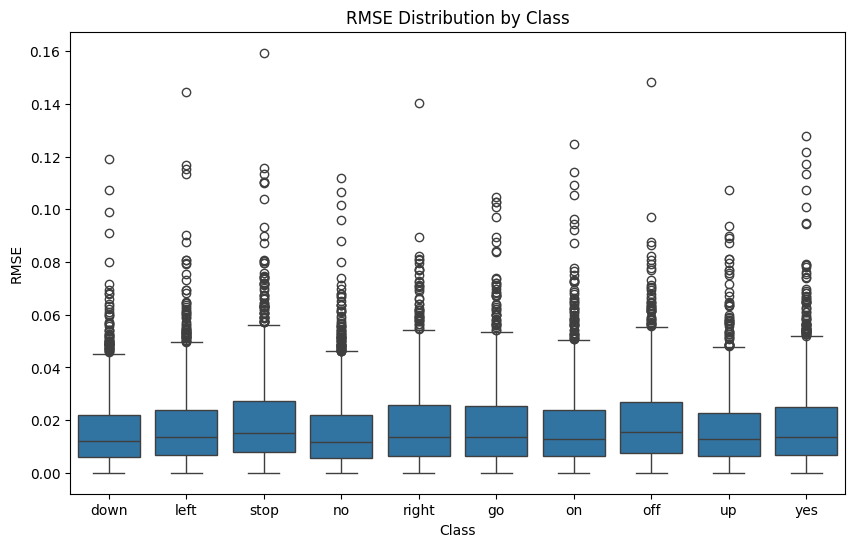

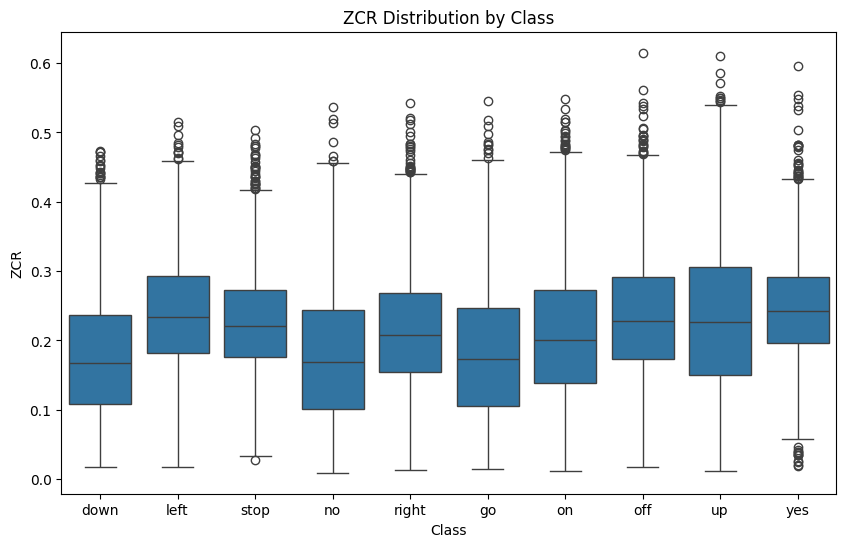

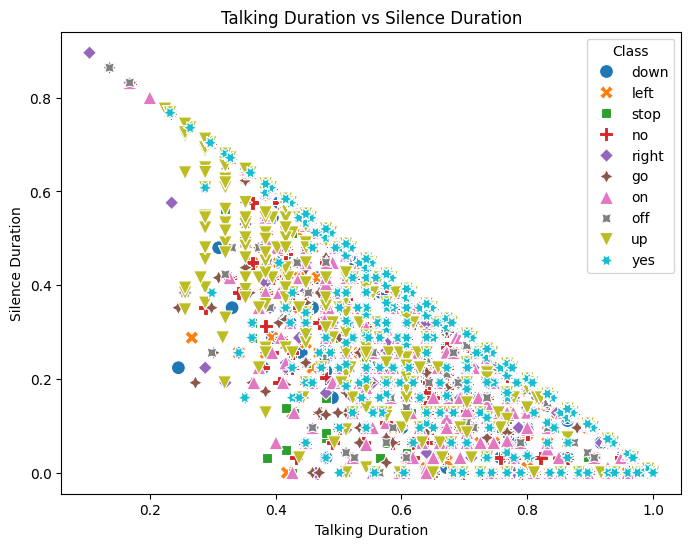

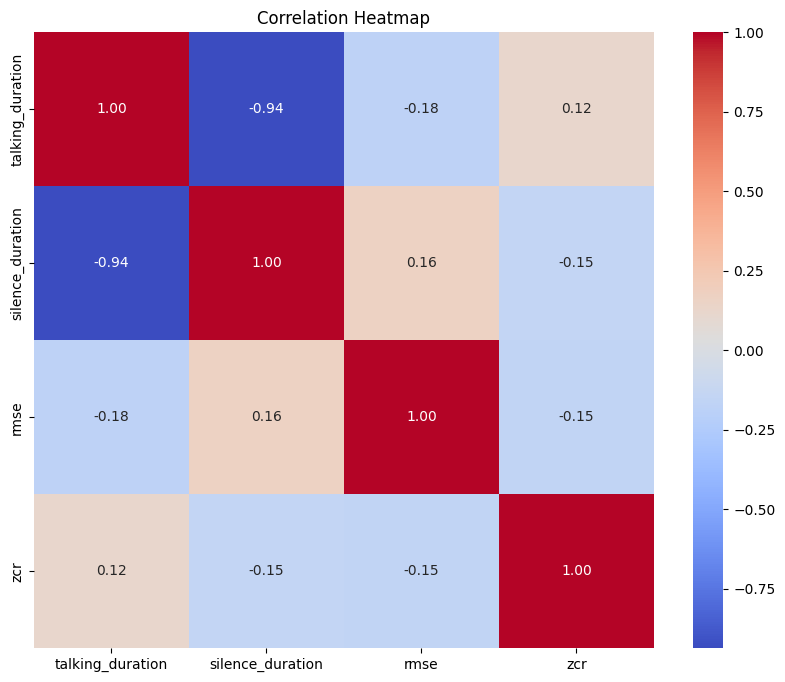

In [21]:
import seaborn as sns

# Plot 1: Talking and Silence Duration by Class
plt.figure(figsize=(12, 6))
sns.barplot(data=df.melt(id_vars=['class'], value_vars=['talking_duration', 'silence_duration']),
            x='class', y='value', hue='variable')
plt.title('Talking and Silence Duration by Class')
plt.ylabel('Duration')
plt.xlabel('Class')
plt.legend(title='Metric')
plt.show()

class_track_counts = df.groupby(['class', 'speaker_track_id']).size().reset_index(name='count')

# Create a bar plot showing the count of unique speaker_track_id occurrences for each class
plt.figure(figsize=(12, 8))
sns.barplot(data=class_track_counts, x='class', y='count', hue='speaker_track_id')
plt.title('Count of Unique Speaker Track IDs by Class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.legend(title='Speaker Track ID')
plt.show()
# Plot 3: RMSE Distribution by Class
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='class', y='rmse')
plt.title('RMSE Distribution by Class')
plt.ylabel('RMSE')
plt.xlabel('Class')
plt.show()

# Plot 4: ZCR Distribution by Class
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='class', y='zcr')
plt.title('ZCR Distribution by Class')
plt.ylabel('ZCR')
plt.xlabel('Class')
plt.show()

# Plot 5: Scatterplot of Talking Duration vs Silence Duration
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='talking_duration', y='silence_duration', hue='class', style='class', s=100)
plt.title('Talking Duration vs Silence Duration')
plt.xlabel('Talking Duration')
plt.ylabel('Silence Duration')
plt.legend(title='Class')
plt.show()

# Additional Plot: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[['talking_duration', 'silence_duration', 'rmse', 'zcr']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
